In [23]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
import torch
import numpy as np
import pandas as pd
import json
import matplotlib.patches as mpatches
from torchvision import datasets, transforms
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from torchvision.utils import make_grid, save_image

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
def argmax_first_and_last(a):
    b = torch.stack([torch.arange(a.shape[1])] * a.shape[0])
    max_values, _ = torch.max(a, dim=1)
    b[a != max_values[:, None]] = a.shape[1]
    first_max, _ = torch.min(b, dim=1)
    b[a != max_values[:, None]] = -1
    last_max, _ = torch.max(b, dim=1)
    return first_max, last_max

def arrowed_spines(ax=None, arrow_length=20, labels=('', ''), arrowprops=None):
    xlabel, ylabel = labels
    if ax is None:
        ax = plt.gca()
    if arrowprops is None:
        arrowprops = dict(arrowstyle='<|-', facecolor='black')

    for i, spine in enumerate(['left']):
        # Set up the annotation parameters
        t = ax.spines[spine].get_transform()
        xy, xycoords = [1, 0], ('axes fraction', t)
        xytext, textcoords = [arrow_length, 0], ('offset points', t)
        ha, va = 'left', 'bottom'

        # If axis is reversed, draw the arrow the other way
        top, bottom = ax.spines[spine].axis.get_view_interval()
        if top < bottom:
            xy[0] = 0
            xytext[0] *= -1
            ha, va = 'right', 'top'

        #if spine is 'bottom':
        #    xarrow = ax.annotate(xlabel, xy, xycoords=xycoords, xytext=xytext, 
        #                textcoords=textcoords, ha=ha, va='center',
        #                arrowprops=arrowprops)
        #else:
        yarrow = ax.annotate(ylabel, xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], 
                        ha='center', va=va, arrowprops=arrowprops)
    return yarrow


def show(img, title=None, saving_path=None ):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    if saving_path is not None:
        plt.savefig(saving_path)
    plt.show()
    
def show_axis(img,axis):
    npimg = img.numpy()
    axis.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    axis.set_axis_off()


def salt_pepper_noise(input, proba_ones, idx_param=None):
    to_out = input.clone()
    mask = torch.bernoulli(torch.ones_like(input) * proba_ones).bool()
    to_out[mask] = torch.bernoulli(torch.ones_like(input[mask]) * 0.5)
    return to_out

def white_noise(input, std):
        input_filtered = input + std * torch.randn_like(input)
        return input_filtered
    
def Entropy(logsoftmax):
    b = torch.exp(logsoftmax)*logsoftmax
    entropy = -1*b.sum(dim=-1)
    return entropy


#def img_to_np(img):
#    npimg = img.numpy()
#    #to_out = np.transpose(npimg, (1, 2, 0))
#    return to_out
            

In [3]:
## TO DO
## 1 - normalize the image for Gaussian filtering
## 2 - Do the CNN baseline
## 3 - Do a bar graph for beta
## 4 - Try with a l2 loss decoder (i.e. gaussian input)
## 5 - Try with a Gaussian mixture prior

# Fig 2

In [4]:
def curve_accu(ax) :
    
    base_path = '/media/data_cifs_lrs/projects/prj_predcoding/'
    path_EVAL_DB = base_path + 'db_EVAL_3.csv'
    EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)
    with open(base_path + 'config_eval.json') as config_file:
        dico_config = json.load(config_file)
    #x = np.linspace(0.0, 1.0, 8)
    cmap = plt.cm.get_cmap('tab20c')
    all_color = [cmap.colors[19], cmap.colors[2], cmap.colors[0]]
    color = cmap.colors[2]
    
    #color = 'lightgray'
    text_size = 13
    beta = 1
    nb_it = 500.0
    zdim = 15.0

    list_it = np.arange(0,501,25)
    tick_position = [1,5,9,13]

    my_noise_list = ['NoNoise', 'WhiteNoise']

    my_param_list = [0.4,0.6,0.8]
    i = 0
    for noise_type in my_noise_list:
        if noise_type != 'NoNoise':
            i_init=i
            model_type = 'IVAE'
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == 'NoNoise') & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
            accu_IVAE = np.stack([torch.load(file)['accuracy'] for file in out_IVAE], 0)
            accu_IVAE_mean = accu_IVAE[:,-1].mean(0)
            accu_IVAE_std = accu_IVAE[:,-1].std(0)
            ax.bar(i, accu_IVAE_mean, yerr=accu_IVAE_std, width=0.7, color=color, linewidth=2, linestyle='-', edgecolor='black')
            i=i+1

            model_type = 'PCN'
            out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == 'NoNoise') & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
            accu_PCN = np.stack([torch.load(file)['accuracy'] for file in out_PCN], 0)
            accu_PCN_mean = accu_PCN[:,-1].mean(0)
            accu_PCN_std = accu_PCN[:,-1].std(0)
            ax.bar(i, accu_PCN_mean, yerr=accu_PCN_std,  width=0.7, color=color, linewidth=2, linestyle=':', edgecolor='black')
            i=i+1

            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0),
                              'path_to_results'].values
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_VAE], 0)
            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            ax.bar(i, accu_VAE_mean, yerr=accu_VAE_std,  width=0.7, color=color, linewidth=2, linestyle='--', edgecolor='black')

            model_type = 'CL'
            out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['transform'] == 'NoNoise') & \
                     (EVAL_db['normalize_output'] == 1.0), 'path_to_results'].values[0]
            accu_CL = torch.load(  out_CL)['accuracy']
            accu_CL = accu_CL.cpu().numpy()
            ax.plot([i_init-0.5,i+0.5], [accu_CL,accu_CL],linestyle='-.',color='black',linewidth=2)
            i=i+2
            
            for idx_param, param in enumerate(my_param_list):
                i_init=i
                model_type = 'IVAE'
                out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
                accu_IVAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_IVAE], 0)
                accu_IVAE_mean = accu_IVAE[:,-1].mean(0)
                accu_IVAE_std = accu_IVAE[:,-1].std(0)
                ax.bar(i, accu_IVAE_mean, yerr=accu_IVAE_std, width=0.7, color=color, linewidth=2, linestyle='-', edgecolor='black')
                i+=1
                
                model_type = 'PCN'
                out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
                accu_PCN = np.stack([torch.load(
                    file)['accuracy'] for file in out_PCN], 0)
                accu_PCN_mean = accu_PCN[:,-1].mean(0)
                accu_PCN_std = accu_PCN[:,-1].std(0)
                ax.bar(i, accu_PCN_mean, yerr=accu_PCN_std, width=0.7, color=color, linewidth=2, linestyle=':', edgecolor='black')
                i+=1
                
                model_type = 'VAE'
                out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 
                                      'path_to_results'].values
                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_VAE], 0)
                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                ax.bar(i, accu_VAE_mean, yerr=accu_VAE_std, width=0.7, color=color, linewidth=2, linestyle='--', edgecolor='black')
                
                model_type = 'CL'
                out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                             (EVAL_db['transform'] == noise_type) & \
                             (EVAL_db['normalize_output'] == 1.0) & \
                             (EVAL_db['param'] == param), 'path_to_results'].values[0]
                accu_CL = torch.load(  out_CL)['accuracy']
                accu_CL = accu_CL.cpu().numpy()
                ax.plot([i_init-0.5,i+0.5], [accu_CL,accu_CL],linestyle='-.',color='black')
                #ax.plot(i, accu_CL,'*', color='black')
                i=i+2
        ax.set_xticks(tick_position)

    return ax



In [5]:
def curve_beta(ax):
    base_path = '/media/data_cifs_lrs/projects/prj_predcoding/'
    path_EVAL_DB = base_path + 'db_EVAL_3.csv'
    EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)
    cmap = plt.cm.get_cmap('tab20c')
    all_color = [cmap.colors[19], cmap.colors[2], cmap.colors[0]]
    text_size = 13
    nb_it = 500.0
    zdim = 15.0
    i = 0
    
    my_param_list = [0.4,0.6,0.8]
    my_beta_list=[0,1,2]
    idx_noise=-1

    #all_bars = []
    tick_position = [1,5,9,13]
    my_noise_list = ['NoNoise', 'WhiteNoise']
    for noise_type in my_noise_list:

        if noise_type != 'NoNoise':



            i=0
            for idx_beta, beta in enumerate(my_beta_list):
                model_type = 'IVAE'
                out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == 'NoNoise') & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_IVAE], 0)

                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)

                bars = ax.bar(i, accu_VAE_mean[-1], width=0.7, color=all_color[idx_beta], bottom=0, linewidth=2, linestyle='-', edgecolor='black', yerr=accu_VAE_std[-1])

                #all_bars.append(bars)
                i=i+1
            i=i+0.5
            #ax.vlines(i-0.5, 0,100, linestyles='dashed', color='black')
            i=i+0.5
            for idx_param, param in enumerate(my_param_list):
                for idx_beta, beta in enumerate(my_beta_list):
                    model_type = 'IVAE'
                    out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                             (EVAL_db['model_z_dim'] == zdim) & \
                             (EVAL_db['beta'] == beta) & \
                             (EVAL_db['transform'] == noise_type) & \
                             (EVAL_db['normalize_output'] == 1.0) & \
                             #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                             (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                             (EVAL_db['param'] == param), 'path_to_results'].values

                    accu_VAE = np.stack([torch.load(
                        file)['accuracy'] for file in out_IVAE], 0)

                    accu_VAE_mean = accu_VAE.mean(0)
                    accu_VAE_std = accu_VAE.std(0)
                    bars = ax.bar(i, accu_VAE_mean[-1], width=0.7, color=all_color[idx_beta], bottom=0, linewidth=2, linestyle='-', edgecolor='black', yerr=accu_VAE_std[-1])

                    #all_bars.append(bars)
                    i = i+1
                i = i+1
        ax.set_xticks(tick_position)
    return ax

In [6]:
def curve_refinement(ax):
    base_path = '/media/data_cifs_lrs/projects/prj_predcoding/'
    path_EVAL_DB = base_path + 'db_EVAL_3.csv'

    EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)

    with open(base_path + 'config_eval.json') as config_file:
        dico_config = json.load(config_file)

    beta = 1

    nb_it = 500.0
    zdim = 15.0
    list_it = np.arange(0,501,25)


    my_noise_list = ['NoNoise', 'WhiteNoise']
    #my_param_list = [0.2,0.4,0.6]
    my_param_list = [0.6]
    for noise_type in my_noise_list:
        if noise_type != 'NoNoise':
            for idx_param, param in enumerate(my_param_list):
                model_type = 'VAE'
                out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 
                                      'path_to_results'].values

                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_VAE], 0)
                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                x = [list_it[0],list_it[-1]]
                ax.plot(x, [accu_VAE_mean,accu_VAE_mean], linestyle='--', color='black', lw=2.5)
                #ax[0].fill_between(x, (y-accu_VAE_std), (y+accu_VAE_std), color=color_list[idx_param], alpha=.1)

            for idx_param, param in enumerate(my_param_list):
                model_type = 'PCN'

                out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values

                accu_PCN = np.stack([torch.load(
                    file)['accuracy'] for file in out_PCN], 0)
                accu_PCN_mean = accu_PCN.mean(0)
                accu_PCN_std = accu_PCN.std(0)

                x = list_it
                y = np.array(accu_PCN_mean)

                ax.plot(x, y, linestyle=':', color='black', lw=2.5)
                #ax.fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)


            for idx_param, param in enumerate(my_param_list):
                model_type = 'IVAE'
                out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
                accu_IVAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_IVAE], 0)
                accu_IVAE_mean = accu_IVAE.mean(0)
                accu_IVAE_std = accu_IVAE.std(0)
                x = list_it
                y = np.array(accu_IVAE_mean)


                ax.plot(x, y, linestyle='-', color='black', lw=2.5)
                #ax.fill_between(x, (y-accu_IVAE_std), (y+accu_IVAE_std), color=color_list[idx_param], alpha=.1) 
                
    path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_PCN_[512,256,15]_beta=1.0/"
    type_to_plot = 'WhiteNoise_0.6'
    to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
    image_reco_PCN = torch.tensor(torch.load(to_plot_reco))



    path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_IVAE_[512,256,15]_beta=1.0/"
    to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
    image_reco_IVAE = torch.tensor(torch.load(to_plot_reco))
    
    path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_VAE_[512,256,15]_beta=1.0/"
    to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
    image_reco_VAE = torch.tensor(torch.load(to_plot_reco))
    
    to_plot_reshape_PCN = image_reco_PCN.reshape(21,256,1,28,28)
    to_plot_reshape_IVAE = image_reco_IVAE.reshape(21,256,1,28,28)
    

    image_PCN = to_plot_reshape_PCN[[0,2,4,10],98,0,:,:]
    image_IVAE = to_plot_reshape_IVAE[[0,2,4,10],98,0,:,:]
    

    image_VAE = image_reco_VAE[98,0,:,:]

    
    all_image = torch.stack([image_PCN, image_IVAE],dim=0)
    
    idx_image_list = [0, 50, 100, 250]
    
    y_position_list = [(72,85),(81,92),(88.7,94),(91,95)]
    for idx_x_pos, x_pos in enumerate(idx_image_list):
        ax.vlines(x_pos,70,y_position_list[idx_x_pos][1],alpha=0.2,lw=1)

    linestyle_list=[':','-']
    for idx_iteration, x_pos in enumerate(idx_image_list):         
            for idx_y, y_position in enumerate(y_position_list[idx_iteration]): 
                im = OffsetImage(all_image[idx_y, idx_iteration,:,:], zoom=0.8, interpolation='nearest', cmap='Greys')
                ab = AnnotationBbox(im,(x_pos, y_position),xycoords='data', pad=0.2, frameon=True, bboxprops=dict(edgecolor='black',lw=2,linestyle=linestyle_list[idx_y]))
                ax.add_artist(ab)
    
    im = OffsetImage(image_VAE, zoom=0.8, interpolation='nearest', cmap='Greys')
    ab = AnnotationBbox(im,(250, 76.5),xycoords='data', pad=0.2, frameon=True, bboxprops=dict(edgecolor='black',lw=2,linestyle='--'))
    ax.add_artist(ab)
                


    return ax



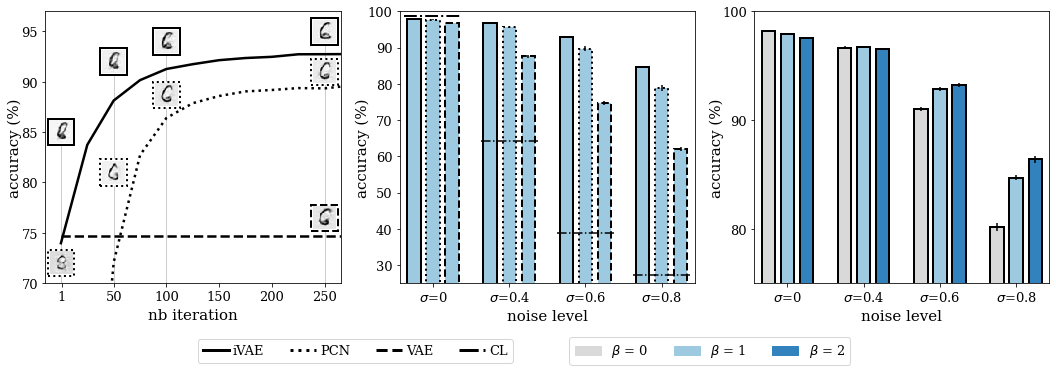

In [7]:
save_fig = False
fig, ax = plt.subplots(1, 3 ,figsize=(18,5))
ticklabel_size=13
ax[0] = curve_refinement(ax[0])
ax[1] = curve_accu(ax[1])
ax[2] = curve_beta(ax[2])

ax[0].set_ylim(70,97)
ax[0].set_xticklabels(['1','50','100','150','200','250'])
ax[0].set_xticks([1,50,100,150,200,250])
ax[0].tick_params(labelsize=ticklabel_size)
ax[0].set_xlim(-15,265)

ax[0].set_xlabel(r'nb iteration', fontsize=15, labelpad=5)
ax[0].set_ylabel(r'accuracy (%)', fontsize=15, labelpad=0)



my_param_list = [0.4,0.6,0.8]
ax[1].set_ylim(25,100)
ax[1].set_xlim(-0.75,14.75)
ax[1].set_xlabel('noise level', fontsize=15, labelpad=5)
ax[1].set_ylabel(r'accuracy (%)', fontsize=15, labelpad=-2)
ax[1].tick_params(labelsize=ticklabel_size)
ax[1].set_xticklabels([r'$\sigma$=0']+ [r'$\sigma$={0}'.format(str(param)) for param in my_param_list ], fontsize=ticklabel_size)



ax[2].set_xticklabels([r'$\sigma$=0']+ [r'$\sigma$={0}'.format(str(param)) for param in my_param_list ], fontsize=ticklabel_size)
ax[2].tick_params(labelsize=ticklabel_size)
ax[2].set_yticks([80,90,100])
ax[2].set_yticklabels(['80','90','100'], fontsize=ticklabel_size)
ax[2].set_ylim(75,100)
ax[2].set_xlabel('noise level', fontsize=15, labelpad=5)
ax[2].set_ylabel(r'accuracy (%)', fontsize=15, labelpad=-2)
ax[2].set_xlim(-0.75,14.75)


my_beta_list= [0,1,2]
cmap = plt.cm.get_cmap('tab20c')
all_color = [cmap.colors[19], cmap.colors[2], cmap.colors[0]]
patches = []
for idx_beta, color in enumerate(all_color):
    patches.append(mpatches.Patch(color=color, label=r'$\beta$ = {0}'.format(my_beta_list[idx_beta])))
out = ax[2].legend(handles=patches, fontsize=ticklabel_size, loc='center', bbox_to_anchor=(-0.15,-0.25), ncol=3)





        
legend_elements = [Line2D([0], [0], linestyle='-',  color='black', lw=3, label='iVAE'),
                   Line2D([0], [0], linestyle=':',  color='black', lw=3, label='PCN'),
                   Line2D([0], [0], linestyle='--',  color='black', lw=3, label='VAE'),
                   Line2D([0], [0], linestyle='-.',  color='black', lw=3, label='CL')
                  ]

ax[0].legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.05,-0.25), ncol=4, fontsize=ticklabel_size, handletextpad=0.3)

if save_fig:
    plt.savefig('Figure_NeuripsWorkshop/Fig2.pdf', bbox_inches='tight', dpi=400)

## Fig 3

In [8]:
def fig_ELBO_nbit_discard_misclassified(ax):
    path_EVAL_DB = '../db_EVAL.csv'
    EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)
    model_type = 'IVAE'
    out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == 15) & \
                 (EVAL_db['beta'] == 1) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1) & \
                 (EVAL_db['svi_lr_eval'] == 1e-2) & \
                 (EVAL_db['svi_nb_it_eval'] == 500) & \
                 (EVAL_db['denoising_baseline'] == 0) & \
                
                 (EVAL_db['param'] == 0), 
                       'path_to_results'].values[-1]


    dico_result = torch.load('../'+ out_IVAE)
    correct_IVAE = torch.tensor(dico_result['correct_per_sample'])
    ELBO = torch.tensor(dico_result['ELBO'])
    label = torch.tensor(dico_result['labels'])
    
    filter_no_misclassified = correct_IVAE.sum(dim=1) != 0
        
    correct_IVAE = correct_IVAE[filter_no_misclassified,:]    
    
    
    ELBO = ELBO[filter_no_misclassified,:]
    label = label[filter_no_misclassified] 

    digit_list=np.arange(10)
    all_digits_nb_it = []
    for digit in digit_list:
        mask_one_digit = label==digit
        sorted_ELBO_value, sorted_ELBO_idx = torch.sort(ELBO[mask_one_digit][:,0], descending=True)
        correct_IVAE_sorted = correct_IVAE[mask_one_digit][sorted_ELBO_idx]
        first_max, last_max = argmax_first_and_last(correct_IVAE_sorted)      
        centile_size = correct_IVAE_sorted.size(0)//100
        IVAE_nb_it = []
        for idx in range(100):
            IVAE_nb_it.append(first_max[idx*centile_size:(idx+1)*centile_size].float().mean()*25)
            
        all_digits_nb_it.append(IVAE_nb_it)
    
    all_digits_nb_it = torch.tensor(all_digits_nb_it)
    trend=all_digits_nb_it.mean(dim=0)
    error = all_digits_nb_it.std(dim=0)
    ax.plot(np.arange(100), trend, color='black', lw=2)
    ax.fill_between(np.arange(100), (trend-error), (trend+error), color='black', alpha=.1)
    
    return ax

def fig_ELBO_nbit(ax):
    path_EVAL_DB = '../db_EVAL.csv'
    EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)
    model_type = 'IVAE'
    out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == 15) & \
                 (EVAL_db['beta'] == 1) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1) & \
                 (EVAL_db['svi_lr_eval'] == 1e-2) & \
                 (EVAL_db['svi_nb_it_eval'] == 500) & \
                 (EVAL_db['denoising_baseline'] == 0) & \
                
                 (EVAL_db['param'] == 0), 
                       'path_to_results'].values[-1]


    dico_result = torch.load('../'+ out_IVAE)
    correct_IVAE = torch.tensor(dico_result['correct_per_sample'])
    ELBO = torch.tensor(dico_result['ELBO'])
    label = torch.tensor(dico_result['labels'])

    digit_list=np.arange(10)
    all_digits_nb_it = []
    for digit in digit_list:
        mask_one_digit = label==digit
        sorted_ELBO_value, sorted_ELBO_idx = torch.sort(ELBO[mask_one_digit][:,0], descending=True)
        #print(sorted_ELBO)
        correct_IVAE_sorted = correct_IVAE[mask_one_digit][sorted_ELBO_idx]
        centile_size = correct_IVAE_sorted.size(0)//100
        IVAE_nb_it = []
        for idx in range(100):
            IVAE_nb_it.append((correct_IVAE_sorted[idx*centile_size:(idx+1)*centile_size]==0).sum(dim=1).float().mean()*25)

        all_digits_nb_it.append(IVAE_nb_it)
    
    all_digits_nb_it = torch.tensor(all_digits_nb_it)
    trend=all_digits_nb_it.mean(dim=0)
    error = all_digits_nb_it.std(dim=0)
    ax.plot(np.arange(100), trend, color='black', lw=2)
    #ax.errorbar(np.arange(100), all_digits_nb_it.mean(dim=0) , yerr=all_digits_nb_it.std(dim=0))
    ax.fill_between(np.arange(100), (trend-error), (trend+error), color='black', alpha=.1)
    #
    #print(torch.tensor(IVAE_nb_it).mean())


    
    return ax

In [9]:
def fig_sample_ELBO(ax):
    path_EVAL_DB = '../db_EVAL.csv'
    EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)

    model_type = 'IVAE'

    kwargs = {'batch_size': 60000, 'num_workers': 8, 'pin_memory': True,'shuffle': False }
    transform_dataset=transforms.Compose([transforms.ToTensor(),])
    dataset = datasets.QMNIST('../../DataSet/QMNIST/', what='test', transform=transform_dataset)
    test_loader = torch.utils.data.DataLoader(dataset, **kwargs)
    for batch_idx, (data, _) in enumerate(test_loader):
        all_image=data

    grid_param = {'padding': 2, 'normalize': True,
                  'pad_value': 1,
                  'nrow': 3}

    nb_it=500

    out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == 15) & \
                 (EVAL_db['beta'] == 1) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1) & \
                 (EVAL_db['svi_lr_eval'] == 1e-2) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                 (EVAL_db['denoising_baseline'] == 0) & \
                
                 (EVAL_db['param'] == 0), 
                       'path_to_results'].values[-1]


    dico_result = torch.load('../'+ out_IVAE)
    #correct_IVAE = torch.tensor(dico_result['correct_per_sample'])
    #it_list = np.arange(0,501,25)
    ELBO = torch.tensor(dico_result['ELBO'])
    #print(ELBO.size())
    label = torch.tensor(dico_result['labels'])

    digit_list = np.arange(0,10)
    pick_digit_among_quartile={'0':[4,5,3,4],
                               '1':[9,2,1,2],
                               '2':[3,4,1,4],
                               '3':[1,2,3,0],
                               '4':[4,9,5,3],
                               '5':[0,1,5,5],
                               '6':[1,2,4,6],
                               '7':[4,9,4,6],
                               '8':[5,3,4,8],
                               '9':[2,3,2,4]}
    for digit in digit_list:
    
        mask_one_digit = label==digit
        sorted_ELBO_value, sorted_ELBO_idx = torch.sort(ELBO[mask_one_digit][:,0], descending=True)
        data_sorted = all_image[mask_one_digit][sorted_ELBO_idx]
        quartile_size = sorted_ELBO_value.size(0)//4
        idx_to_pick = pick_digit_among_quartile[str(digit)]
        for quartile in range(4):
            im = OffsetImage(data_sorted[quartile*quartile_size + idx_to_pick[quartile],0,:,:], zoom=1.6, interpolation='nearest', cmap='Greys')
            ab = AnnotationBbox(im,(digit, quartile),xycoords='data',frameon=False)
            ax.add_artist(ab)
            #img_to_plot = make_grid(data_sorted[quartile*quartile_size:quartile*quartile_size+10,:,:,:], **grid_param)
            #show(img_to_plot)
            #plt.show()


    return ax




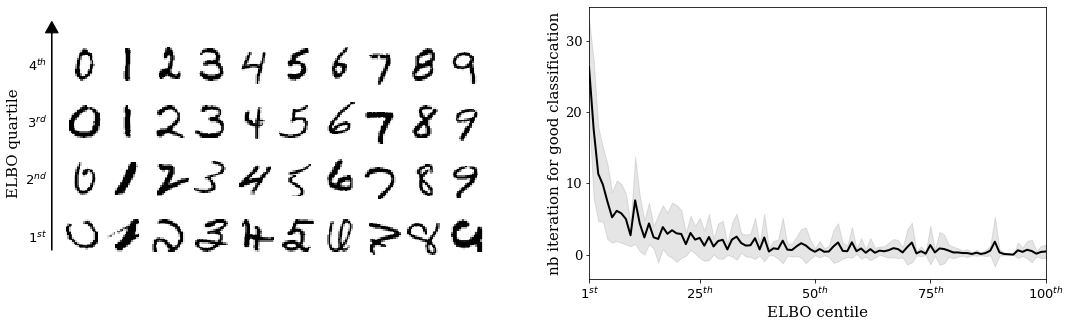

In [11]:
save_fig = False
fig, ax = plt.subplots(1, 2 ,figsize=(18,5))
ax[0] = fig_sample_ELBO(ax[0])
ax[1] = fig_ELBO_nbit_discard_misclassified(ax[1])
ticklabel_size = 13

ax[0].set_xlim(-1,9.75);
ax[0].set_ylim(-0.75,4);

#ax[0].set_xlabel('digit class', fontsize=15, labelpad=5);
ax[0].set_ylabel('ELBO quartile', fontsize=15);

ax[0].tick_params(axis=u'y', which=u'both',length=0, pad=-6)
ax[0].set_yticklabels([r'$1^{st}$',r'$2^{nd}$',r'$3^{rd}$',r'$4^{th}$'], fontsize=ticklabel_size);
ax[0].set_yticks([0,1,2,3]);
ax[0].spines['right'].set_visible(False);
ax[0].spines['top'].set_visible(False);
ax[0].spines['bottom'].set_visible(False);
ax[0].spines['left'].set_visible(False);
ax[0].arrow(-0.75,-.25,0,4,fc='k',ec='k',head_width=0.3, head_length=0.2,  length_includes_head= True)
ax[0].set_xticks([]);

ax[1].tick_params(labelsize=ticklabel_size)
ax[1].set_xlim(-0,35);
ax[1].set_ylabel('nb iteration for good classification', fontsize=15);
ax[1].set_xlabel('ELBO centile', fontsize=15);

ax[1].set_yticklabels(['0','10','20','30'], fontsize=ticklabel_size);
ax[1].set_yticks([0,10,20,30]);


ax[1].set_xticklabels([r'$1^{st}$',r'$25^{th}$',r'$50^{th}$',r'$75^{th}$',r'$100^{th}$'], fontsize=ticklabel_size);
ax[1].set_xticks([0,24,49,74,99]);

if save_fig : 
    plt.savefig('Figure_NeuripsWorkshop/Fig3.pdf', bbox_inches='tight', dpi=400)

## Fig S6

### Blurring 

Input


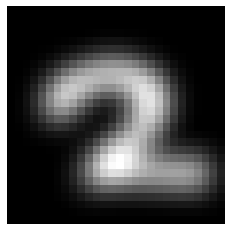

Reconstruction PCN


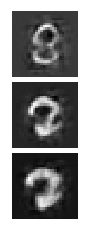

Reconstruction IVAE


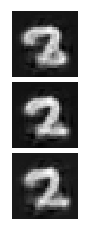

Reconstruction VAE


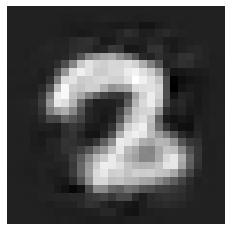

Target


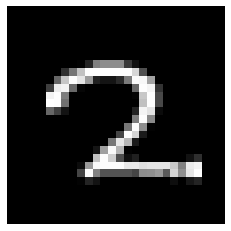

In [24]:
explore = False
save_fig = True

path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_VAE_[512,256,15]_beta=1.0/"
type_to_plot = 'Blurring_2'
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
image_reco_VAE = torch.tensor(torch.load(to_plot_reco))

path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_PCN_[512,256,15]_beta=1.0/"
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
to_plot_original = path_to_load + "image_clear_"+type_to_plot+".pkl"
to_plot_input = path_to_load + "image_blurred_"+type_to_plot+".pkl"

image_reco_PCN = torch.tensor(torch.load(to_plot_reco))
image_original_PCN = torch.tensor(torch.load(to_plot_original))
image_input_PCN = torch.tensor(torch.load(to_plot_input))


path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_IVAE_[512,256,15]_beta=1.0/"
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
to_plot_original = path_to_load + "image_clear_"+type_to_plot+".pkl"
to_plot_input = path_to_load + "image_blurred_"+type_to_plot+".pkl"

image_reco_IVAE = torch.tensor(torch.load(to_plot_reco))
image_original_IVAE = torch.tensor(torch.load(to_plot_original))
image_input_IVAE = torch.tensor(torch.load(to_plot_input))


to_plot_reshape_PCN = image_reco_PCN.reshape(21,256,1,28,28)
to_plot_reshape_IVAE = image_reco_IVAE.reshape(21,256,1,28,28)


if explore==False:
    idx=77
    grid_param = {'padding': 2, 'normalize': False, 'scale_each':True,
                  'pad_value': 1,
                  'nrow': 1}
    print('Input')        
    to_plot = image_input_IVAE[idx,:,:,:]
    to_plot = make_grid(to_plot, **grid_param)
    if save_fig:
        save_image(to_plot,'Figure_NeuripsWorkshop/FigS6/Input_Blurring.pdf', format='pdf')
    show(to_plot)

    
    print('Reconstruction PCN')    
    to_output_PCN = to_plot_reshape_PCN[[0,10,20],idx,:,:,:]
    to_plot = make_grid(to_output_PCN, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/PCN_Blurring.pdf',format='pdf')
    show(to_plot)

    print('Reconstruction IVAE')
    to_output_IVAE = to_plot_reshape_IVAE[[0,10,20],idx,:,:,:]
    to_plot = make_grid(to_output_IVAE, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/IVAE_Blurring.pdf', format='pdf')
    show(to_plot)

    print('Reconstruction VAE')
    to_output_VAE = image_reco_VAE[idx,:,:,:]
    to_plot = make_grid(to_output_VAE, **grid_param)
    if save_fig :
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/VAE_Blurring.pdf', format='pdf')
    show(to_plot)
    
    print('Target')
    to_plot = image_original_IVAE[idx,:,:,:]
    to_plot = make_grid(to_plot, **grid_param)
    if save_fig :
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/Target_B.pdf', format='pdf')
    show(to_plot)

else : 
    grid_param = {'padding': 2, 'normalize': False, 'scale_each':True,
                  'pad_value': 1,
                  'nrow': 8}
    
    for i in range(32):
        print('batch : {0}'.format(i))
        print('Target')
        to_plot = make_grid(image_original_PCN[8*i:(i+1)*8,:,:,:], **grid_param)

        show(to_plot)

        print('Reconstruction PCN')
        to_plot = to_plot_reshape_PCN[[0,10,20],8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        #to_plot = to_plot_reshape[[0,10,20],114:115,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Reconstruction IVAE')
        to_plot = to_plot_reshape_IVAE[[0,10,20],8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Reconstruction VAE')
        to_plot = image_reco_VAE[8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Input')
        to_plot = make_grid(image_input_PCN[8*i:(i+1)*8,:,:,:], **grid_param)
        show(to_plot)
        print('\n\n')



### White noise 

Input


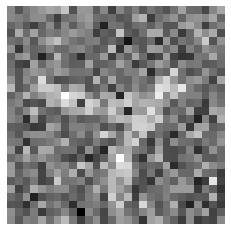

Reconstruction PCN


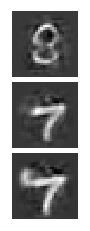

Reconstruction IVAE


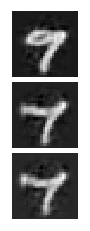

Reconstruction VAE


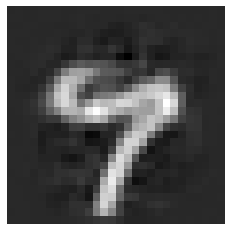

Target


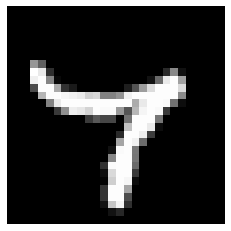

In [25]:
explore = False
save_fig = True
path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_VAE_[512,256,15]_beta=1.0/"
type_to_plot = 'WhiteNoise_0.6'
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
image_reco_VAE = torch.tensor(torch.load(to_plot_reco))

path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_PCN_[512,256,15]_beta=1.0/"
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
to_plot_original = path_to_load + "image_clear_"+type_to_plot+".pkl"
to_plot_input = path_to_load + "image_blurred_"+type_to_plot+".pkl"

image_reco_PCN = torch.tensor(torch.load(to_plot_reco))
image_original_PCN = torch.tensor(torch.load(to_plot_original))
image_input_PCN = torch.tensor(torch.load(to_plot_input))


path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_IVAE_[512,256,15]_beta=1.0/"
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
to_plot_original = path_to_load + "image_clear_"+type_to_plot+".pkl"
to_plot_input = path_to_load + "image_blurred_"+type_to_plot+".pkl"

image_reco_IVAE = torch.tensor(torch.load(to_plot_reco))
image_original_IVAE = torch.tensor(torch.load(to_plot_original))
image_input_IVAE = torch.tensor(torch.load(to_plot_input))





to_plot_reshape_PCN = image_reco_PCN.reshape(21,256,1,28,28)
to_plot_reshape_IVAE = image_reco_IVAE.reshape(21,256,1,28,28)


if explore==False:
    idx=15*8 +4
    grid_param = {'padding': 2, 'normalize': False, 'scale_each':True,
                  'pad_value': 1,
                  'nrow': 1}
    
    print('Input')        
    to_plot = image_input_IVAE[idx,:,:,:]
    to_plot = make_grid(to_plot, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/Input_WhiteNoise.pdf', format='pdf')
    show(to_plot)
    
    print('Reconstruction PCN')    
    to_output_PCN = to_plot_reshape_PCN[[0,10,20],idx,:,:,:]
    to_plot = make_grid(to_output_PCN, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/PCN_WhiteNoise.pdf', format='pdf')
    show(to_plot)

    #to_output_IVAE = torch.zeros(4,1,28,28)
    print('Reconstruction IVAE')
    to_output_IVAE = to_plot_reshape_IVAE[[0,10,20],idx,:,:,:]
    to_plot = make_grid(to_output_IVAE, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/IVAE_WhiteNoise.pdf', format='pdf')
    show(to_plot)

    print('Reconstruction VAE')
    to_output_VAE = image_reco_VAE[idx,:,:,:]
    to_plot = make_grid(to_output_VAE, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/VAE_WhiteNoise.pdf', format='pdf')
    show(to_plot)
    
    print('Target')

    to_plot = image_original_IVAE[idx,:,:,:]
    to_plot = make_grid(to_plot, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/Target_WhiteNoise.pdf', format='pdf')
    show(to_plot)

else : 
    grid_param = {'padding': 2, 'normalize': False, 'scale_each':True,
                  'pad_value': 1,
                  'nrow': 8}
    
    for i in range(32):
        print('batch : {0}'.format(i))
        print('Target')
        to_plot = make_grid(image_original_PCN[8*i:(i+1)*8,:,:,:], **grid_param)
        show(to_plot)

        print('Reconstruction PCN')
        to_plot = to_plot_reshape_PCN[[0,10,20],8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Reconstruction IVAE')
        to_plot = to_plot_reshape_IVAE[[0,10,20],8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Reconstruction VAE')
        to_plot = image_reco_VAE[8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Input')
        to_plot = make_grid(image_input_PCN[8*i:(i+1)*8,:,:,:], **grid_param)
        show(to_plot)
        print('\n\n')




### Salt and Pepper

Input


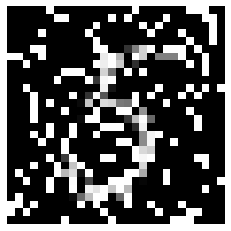

Reconstruction IVAE


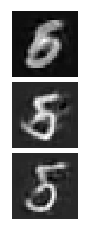

Reconstruction PCN


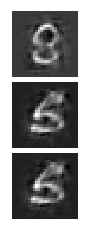

Reconstruction VAE


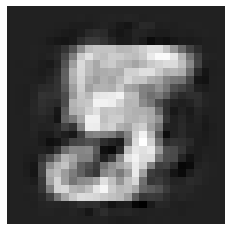

Target


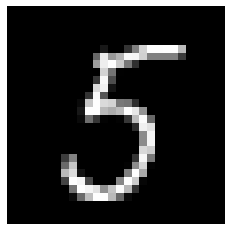

In [26]:
explore=False
save_fig = True

path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_VAE_[512,256,15]_beta=1.0/"
type_to_plot = 'SaltPepper_0.4'
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
image_reco_VAE = torch.tensor(torch.load(to_plot_reco))

path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_PCN_[512,256,15]_beta=1.0/"
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
to_plot_original = path_to_load + "image_clear_"+type_to_plot+".pkl"
to_plot_input = path_to_load + "image_blurred_"+type_to_plot+".pkl"

image_reco_PCN = torch.tensor(torch.load(to_plot_reco))
image_original_PCN = torch.tensor(torch.load(to_plot_original))
image_input_PCN = torch.tensor(torch.load(to_plot_input))


path_to_load = "../../prj_probcod_exps/SAVE_DATA_IMAGE_EVAL_lrsvi=1e-3_nb_it=500_IVAE_[512,256,15]_beta=1.0/"
to_plot_reco = path_to_load + "image_reco_"+type_to_plot+".pkl"
to_plot_original = path_to_load + "image_clear_"+type_to_plot+".pkl"
to_plot_input = path_to_load + "image_blurred_"+type_to_plot+".pkl"

image_reco_IVAE = torch.tensor(torch.load(to_plot_reco))
image_original_IVAE = torch.tensor(torch.load(to_plot_original))
image_input_IVAE = torch.tensor(torch.load(to_plot_input))





to_plot_reshape_PCN = image_reco_PCN.reshape(21,256,1,28,28)
to_plot_reshape_IVAE = image_reco_IVAE.reshape(21,256,1,28,28)


if explore==False:
    idx=31*8 + 5
    grid_param = {'padding': 2, 'normalize': False, 'scale_each':True,
                  'pad_value': 1,
                  'nrow': 1}

    print('Input')        
    to_plot_all = image_input_IVAE[idx:idx+1,:,:,:]
    to_plot = make_grid(to_plot_all, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/Input_SaltPepper.pdf', format='pdf')
    show(to_plot)
 
    to_plot_all
    
    print('Reconstruction IVAE')
    to_output_IVAE = to_plot_reshape_IVAE[[0,10,20],idx,:,:,:]
    to_plot = make_grid(to_output_IVAE, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/PCN_SaltPepper.pdf', format='pdf')    
    show(to_plot)
    
    
    print('Reconstruction PCN')    
    to_output_PCN = to_plot_reshape_PCN[[0,10,20],idx,:,:,:]
    to_plot = make_grid(to_output_PCN, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/IVAE_SaltPepper.pdf', format='pdf')    
    show(to_plot)
    
    print('Reconstruction VAE')
    to_output_VAE = image_reco_VAE[idx:idx+1,:,:,:]
    to_plot = make_grid(to_output_VAE, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/VAE_SaltPepper.pdf', format='pdf')    
    show(to_plot)
    
    print('Target')
    to_plot = image_original_IVAE[idx:idx+1,:,:,:]
    to_plot = make_grid(to_plot, **grid_param)
    if save_fig:
        save_image(to_plot, 'Figure_NeuripsWorkshop/FigS6/Target_SaltPepper.pdf', format='pdf')    
    show(to_plot)

else : 
    grid_param = {'padding': 2, 'normalize': False, 'scale_each':True,
                  'pad_value': 1,
                  'nrow': 8}
    
    for i in range(32):
        print('batch : {0}'.format(i))
        print('Target')
        to_plot = make_grid(image_original_PCN[8*i:(i+1)*8,:,:,:], **grid_param)
        show(to_plot)

        print('Reconstruction PCN')
        to_plot = to_plot_reshape_PCN[[0,10,20],8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Reconstruction IVAE')
        to_plot = to_plot_reshape_IVAE[[0,10,20],8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Reconstruction VAE')
        to_plot = image_reco_VAE[8*i:(i+1)*8,:,:,:].reshape(-1,1,28,28)
        img_to_plot = make_grid(to_plot, **grid_param)
        show(img_to_plot)

        print('Input')
        to_plot = make_grid(image_input_PCN[8*i:(i+1)*8,:,:,:], **grid_param)
        show(to_plot)
        print('\n\n')





## Fig S7

dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])
/media/data_cifs_lrs/projects/prj_predcoding/prj_probcod_exps/2020-09-29_08-36-35_EVAL_CL/result_Blurring_1.pth
/media/data_cifs_lrs/projects/prj_predcoding/prj_probcod_exps/2020-09-29_08-36-35_EVAL_CL/result_WhiteNoise_0.2.pth
/media/data_cifs_lrs/projects/prj_predcoding/prj_probcod_exps/2020-09-29_08-36-35_EVAL_CL/result_SaltPepper_0.1.pth


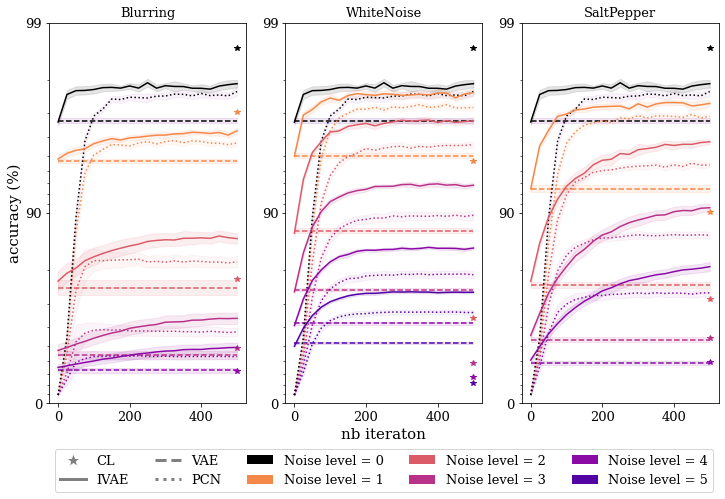

<Figure size 432x288 with 0 Axes>

In [19]:
save_fig = False
with open('../config_eval.json') as config_file:
    dico_config = json.load(config_file)

path_EVAL_DB = '/media/data_cifs_lrs/projects/prj_predcoding/db_EVAL_3.csv'

EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)

cmap = plt.get_cmap('plasma')
x = np.linspace(0.0, 1.0, 8)
# rgb = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = list(reversed(color_list[:6]))
# color_list = ['darkblue','slateblue', 'green', 'purple','red', 'orange']

text_size = 13

beta = 1

fig, ax = plt.subplots(1, 3 ,figsize=(12,7))
nb_it = 500.0
zdim = 15.0
#svi_lr_eval = 5e-3
list_it = np.arange(0,501,25)
print(dico_config.keys())

idx_graph = 0
plots = {}
for noise_type in dico_config.keys():
    if noise_type != 'NoNoise':
        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'CL'
            out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values[0]
            
            if idx_param==0:
                print(out_CL)
            accu_CL = torch.load(  out_CL)['accuracy']
            accu_CL = accu_CL.cpu().numpy()
            accu_CL = 100 - accu_CL
            ax[idx_graph].plot(list_it[-1], accu_CL, '*', color=color_list[idx_param], label=r'CL - $\sigma$={}'.format(param))
            
        ## baseline classifier
        model_type = 'CL'
        out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0), 'path_to_results'].values[0]
        accu_CL = torch.load(  out_CL)['accuracy']
        accu_CL = accu_CL.cpu().numpy()
        
        accu_CL = 100-accu_CL
        
        ax[idx_graph].plot(list_it[-1], accu_CL, '*', color='black', label=r'CL - NoNoise'.format(param))
        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 
                                  'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_VAE], 0)
            accu_VAE = 100 - accu_VAE
            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            x = [list_it[0],list_it[-1]]
            y = np.array([accu_VAE_mean, accu_VAE_mean])

            ax[idx_graph].plot(x, y, '--', color=color_list[idx_param], label=r'VAE - $\sigma$={}'.format(param))
            ax[idx_graph].fill_between(x, (y-accu_VAE_std), (y+accu_VAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline VAE
        model_type = 'VAE'
        out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
             #(EVAL_db['svi_nb_it_eval'] == nb_it) & \ 
                          'path_to_results'].values

        accu_VAE = np.stack([torch.load(
            file)['accuracy'] for file in out_VAE], 0)
        accu_VAE = 100- accu_VAE
        accu_VAE_mean = accu_VAE.mean(0)
        accu_VAE_std = accu_VAE.std(0)
        x = [list_it[0],list_it[-1]]
        y = np.array([accu_VAE_mean, accu_VAE_mean])

        ax[idx_graph].plot(x, y, '--', color='black', label=r'VAE - NoNoise')
        ax[idx_graph].fill_between(x, (y-accu_VAE_std), (y+accu_VAE_std), color=color_list[idx_param], alpha=.1)
        
        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'PCN'

            out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
#                      (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values
            
            accu_PCN = np.stack([torch.load(
                file)['accuracy'] for file in out_PCN], 0)
            accu_PCN = 100-accu_PCN
            accu_PCN_mean = accu_PCN.mean(0)
            accu_PCN_std = accu_PCN.std(0)
            
            x = list_it
            y = np.array(accu_PCN_mean)
            
            ax[idx_graph].plot(x, y, ':', color=color_list[idx_param], alpha=1.0, label=r'PCN - $\sigma$={}'.format(param))
            ax[idx_graph].fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)
            
        ## baseline PCN
        model_type = 'PCN'

        out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
        
        accu_PCN = np.stack([torch.load(file)['accuracy'] for file in out_PCN], 0)
        accu_PCN = 100-accu_PCN
        accu_PCN_mean = accu_PCN.mean(0)
        accu_PCN_std = accu_PCN.std(0)

        x = list_it
        y = np.array(accu_PCN_mean)
        
        ax[idx_graph].plot(x, y, ':', color='black', alpha=1.0, label=r'PCN - NoNoise')
        ax[idx_graph].fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)

        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values

            accu_IVAE = np.stack([torch.load(
                file)['accuracy'] for file in out_IVAE], 0)
            accu_IVAE = 100-accu_IVAE
            accu_IVAE_mean = accu_IVAE.mean(0)
            accu_IVAE_std = accu_IVAE.std(0)
            x = list_it
            y = np.array(accu_IVAE_mean)
            

            ax[idx_graph].plot(x, y, color=color_list[idx_param], label=r'IVAE - $\sigma$={}'.format(param))
            ax[idx_graph].fill_between(x, (y-accu_IVAE_std), (y+accu_IVAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline IVAE
        model_type = 'IVAE'

        out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

        accu_IVAE = np.stack([torch.load(file)['accuracy'] for file in out_IVAE], 0)
        
        accu_IVAE = 100-accu_IVAE
        accu_IVAE_mean = accu_IVAE.mean(0)
        accu_IVAE_std = accu_IVAE.std(0)
        x = list_it
        y = np.array(accu_IVAE_mean)

        ax[idx_graph].plot(x, y, color='black', label=r'IVAE - $\sigma$={}'.format(param))
        ax[idx_graph].fill_between(x, (y-accu_IVAE_std), (y+accu_IVAE_std), color='black', alpha=.1)
        
        #ax[idx_graph].set_title(r'\textbf{' + noise_type + r'}', fontsize=text_size)
        ax[idx_graph].set_title(noise_type, fontsize=text_size)

        ax[idx_graph].set_ylim(1, 100)
        ax[idx_graph].set_yscale('log')
        ax[idx_graph].invert_yaxis()
        ax[idx_graph].set_yticklabels(['100','99','90','0'])
        
        ax[idx_graph].tick_params(labelsize=text_size)
        
        idx_graph+=1    
    
        
# setting labels
ax[1].set_xlabel(r'nb iteraton', fontsize=15)
ax[0].set_ylabel(r'accuracy (%)', fontsize=15)
#ax[1].set_xlabel(r'\textbf{nb iteraton}', fontsize=15)
#ax[0].set_ylabel(r'\textbf{accuracy}', fontsize=15)


    
legend_elements = [Line2D([0], [0], marker='*', color='w', label='CL', markerfacecolor='grey', markersize=15),
                   Line2D([0], [0], linestyle='-',  color='grey', lw=3, label='IVAE'),
                   Line2D([0], [0], linestyle='--', color='grey', lw=3, label='VAE'),
                   Line2D([0], [0], linestyle=':',  color='grey', lw=3, label='PCN'),
                   Patch(facecolor='black',       label='Noise level = 0'),
                   Patch(facecolor=color_list[0], label='Noise level = 1'),
                   Patch(facecolor=color_list[1], label='Noise level = 2'),
                   Patch(facecolor=color_list[2], label='Noise level = 3'),
                   Patch(facecolor=color_list[3], label='Noise level = 4'),
                   Patch(facecolor=color_list[4], label='Noise level = 5')
                  ]

ax[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5,-0.25), ncol=5, fontsize=text_size)
plt.show()

if save_fig:
    plt.savefig('Figure_NeuripsWorkshop/FigS7.pdf', bbox_inches='tight')


## Fig S8

dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])
Blurring
WhiteNoise
SaltPepper


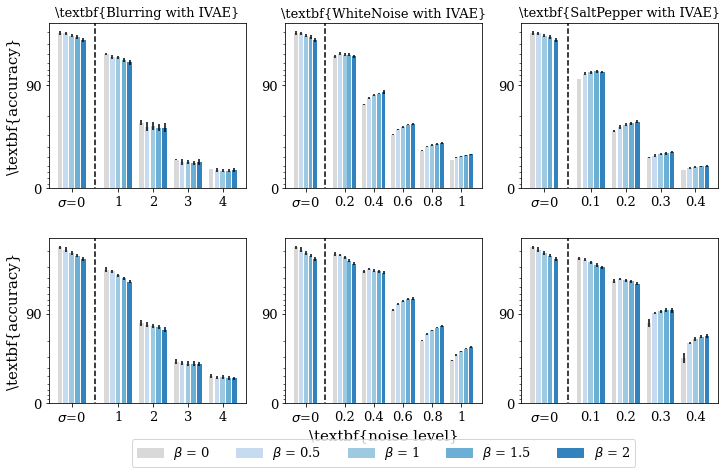

In [21]:
save_fig = True
text_size = 13
cmap = plt.cm.get_cmap('tab20c')
all_color = [cmap.colors[19], cmap.colors[3], cmap.colors[2], cmap.colors[1], cmap.colors[0]]
zdim=15.0
beta_list = [0,0.5,1,1.5,2]
nb_it = 500.0

fig, ax = plt.subplots(2,3,figsize=(12,7))
plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=True)
i = 0
print(dico_config.keys())
idx_noise=-1

all_bars = []
for noise_type in dico_config.keys():
    
    if noise_type != 'NoNoise':
        
        ax[0, idx_noise].set_yscale('log')
        ax[0, idx_noise].invert_yaxis()

        idx_noise += 1
        param_list = dico_config[noise_type]['param']
        tick_position = [2] + [10 +  6*i for i in range(len(param_list))]
        i=0
        print(noise_type)
            
        for idx_beta, beta in enumerate(beta_list):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
             #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                          'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_VAE], 0)

            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            bars = ax[0, idx_noise].bar(i, -accu_VAE_mean, color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std)
        
            all_bars.append(bars)
            i=i+1
        i=i+1
        ax[0, idx_noise].vlines(i, 0,100, linestyles='dashed', color='black')
        i=i+2
        for idx_param, param in enumerate(param_list):
            for idx_beta, beta in enumerate(beta_list):
                model_type = 'VAE'
                out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         #(EVAL_db['svi_lr_eval'] == 1e-2) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
            
                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_VAE], 0)

                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                bars = ax[0, idx_noise].bar(i, -accu_VAE_mean, color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std)
                
                all_bars.append(bars)

                i = i+1
            i = i+1

        ax[0,idx_noise].set_xticks(tick_position)
        ax[0,idx_noise].set_title(noise_type + ' with VAE', fontsize=text_size)
        ax[0,idx_noise].set_xticklabels([r'$\sigma$=0']+ [str(param) for param in param_list ], fontsize=text_size)
        ax[0,idx_noise].tick_params(labelsize=text_size)
    

    
        ###########################################################################################################################
        ###########################################################################################################################
        
        ax[1, idx_noise].set_yscale('log')
        ax[1, idx_noise].invert_yaxis()
        
        i=0
        for idx_beta, beta in enumerate(beta_list):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_IVAE], 0)

            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            
            bars = ax[1, idx_noise].bar(i, -accu_VAE_mean[-1], color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])
            
            all_bars.append(bars)
            i=i+1
        i=i+1
        ax[1, idx_noise].vlines(i, 0,100, linestyles='dashed', color='black')
        i=i+2
        for idx_param, param in enumerate(param_list):
            for idx_beta, beta in enumerate(beta_list):
                model_type = 'IVAE'
                out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
            
                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_IVAE], 0)

                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                bars = ax[1, idx_noise].bar(i, -accu_VAE_mean[-1], color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])

                all_bars.append(bars)
                i = i+1
            i = i+1
        ax[1,idx_noise].set_xticks(tick_position)
        ax[1,idx_noise].set_xticklabels([r'$\sigma$=0']+ [str(param) for param in param_list ], fontsize=text_size)
        ax[1,idx_noise].tick_params(labelsize=text_size)
        
        # set title
        ax[0,idx_noise].set_title(r'\textbf{' + noise_type + r' with IVAE}', fontsize=text_size)
        

ax[0,0].set_yticklabels(['100','99','90','0'])
ax[0,1].set_yticklabels(['100','99','90','0'])
ax[0,2].set_yticklabels(['100','99','90','0'])
ax[1,0].set_yticklabels(['100','99','90','0'])
ax[1,1].set_yticklabels(['100','99','90','0'])
ax[1,2].set_yticklabels(['100','99','90','0'])

ax[1,1].set_xlabel(r'\textbf{noise level}', fontsize=15)

ax[0,0].set_ylabel(r'\textbf{accuracy}', fontsize=15)
ax[1,0].set_ylabel(r'\textbf{accuracy}', fontsize=15)



## just for legend
patches = []
for idx_beta, color in enumerate(all_color):
    patches.append(mpatches.Patch(color=color, label=r'$\beta$ = {0}'.format(beta_list[idx_beta])))
out = plt.legend(handles=patches, fontsize=text_size, loc='center', bbox_to_anchor=(-0.7,-0.3), ncol=5)

plt.subplots_adjust(hspace=0.3)

if save_fig:
    plt.savefig('Figure_NeuripsWorkshop/FigS8.pdf', bbox_inches='tight')
